In [29]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import copy
from Bio import SeqIO
from scipy.spatial.distance import cosine
import math

from utils.similarity import merge_samples

## Récupération et filtrage des données comme décrit dans l'analyse initial

In [30]:
# Récupération et groupement
sim_thresold = 1

data = pd.read_csv('../data/variants.csv', index_col="index").to_dict('records')
grouped = merge_samples(data, 1)
flat_grouped = []
for i, g in enumerate(grouped):
    for v in g:
        v["group"] = i
        flat_grouped.append(v)

data = pd.DataFrame(flat_grouped)

# Catégorisation des colonnes 
data["iteration"] = pd.Categorical(data["iteration"])
data["sample"] = pd.Categorical(data["sample"])
data["group"] = pd.Categorical(data["group"])
data["svtype"] = pd.Categorical(data["svtype"])

# Précalcul de dcertaines donnés pour un accès plus simple
data["choc"] = pd.Categorical(data.apply(lambda x: "cold" if x["sample"] <= 5 else "heat", axis=1))
data["period"] = pd.Categorical(data.apply(lambda x: "before" if x["iteration"] == 15 else ("choc" if x["iteration"] == 30 else "after"), axis=1))

samples = data["sample"].astype(int).unique()
samples.sort()
iterations = data["iteration"].astype(int).unique()
iterations.sort()
chocs = ["cold", "heat"]
periods = ["before", "choc", "after"]

# Copy du jeu de données avants les filtres
data_init = pd.DataFrame(
    columns = data.columns, data = copy.deepcopy(data.values)
)
data_init["iteration"] = pd.Categorical(data["iteration"])
data_init["sample"] = pd.Categorical(data["sample"])
data_init["group"] = pd.Categorical(data["group"])
data_init["svtype"] = pd.Categorical(data["svtype"])

# Filtrage

filter_af = 0.05
filter_depth = 550
filter_dv = int(filter_af * filter_depth)

data_max_dv = data_init.sort_values('dv', ascending=False).drop_duplicates(['group'])
passed = data_max_dv[(data_max_dv["af"] >= filter_af) & (data_max_dv["depth"] >= filter_depth)]["group"].values
data = data[data["group"].isin(passed)]

max_len = 2500
data = data[abs(data["svlen"]) < max_len]

# Nombre de variant après filtrage
print("Nombre de variants uniques :", len(data["group"].unique()))

Nombre de variants uniques : 300


## Extraire les variants qui interfèrent avec un ORF connu

Pour cela on extrait tous les ORFs connues du virues à partir d'un fichier FASTA. Si une variation structurelle chevauche un ou plusieurs ORFs, on noteras lesquel.

In [31]:
orfs = []
margin = 100 # distance maximal de la mutation à l'orf

for seq in SeqIO.parse("../data/ORF.fasta", "fasta"):
    header = seq.description

    locus_tag = header.split("[")[1][:-2].split("=")[1]
    protein_id = header.split("[")[4][:-2].split("=")[1]

    locations = header.split("[")[5][:-2].split("(")[-1].split("=")[-1].split(")")[0].split(",")
    locations = [inter.split("..") for inter in locations]

    complement = 'complement' in header.split("[")[5]
    join = 'join' in header.split("[")[5]

    start_orf = min(locations, key=lambda x: x[0])[0]
    end_orf = min(locations, key=lambda x: x[1])[1]

    orfs += [{'locus_tag': locus_tag, 'protein_id': protein_id, 'location': loc, 'complement': complement, 'join': join} for loc in locations]


def intersected_orfs(pos, end, type):
    result = []
    for o in orfs:
        if type == "INS" and pos - int(o["location"][0]) + margin > 0 and pos - int(o["location"][1]) - margin < 0:
            result.append(o["locus_tag"])
        elif type != "INS" and min(end, int(o["location"][1])) - max(pos, int(o["location"][0])) + margin > 0:
            result.append(o["locus_tag"])
    return result

families = {
    "ORF2": [2, 9],
    "TNFR": [4, 12],
    "ORF22": [22, 24, 137],
    "ORF25": [25, 26, 27, 65, 148, 149],
    "RING": [41, 128, 144, 150],
    "conserved": [19, 33, 46, 47, 48, 61, 71, 72, 78, 79, 80, 90, 92, 99, 107, 123]
}

def get_families(var_orfs):
    f = []
    for orf in var_orfs:
        for k, v in families.items():
            for i in v:
                if orf == f"CyHV3_ORF{i}" or orf.startswith(f"CyHV3_ORF{i}_"):
                    f.append(k)
    return list(set(f))
            
data["orfs"] = data.apply(lambda x: intersected_orfs(x["pos"], x["end"], x["svtype"]), axis=1)
data["families"] = data.apply(lambda x: get_families(x["orfs"]), axis=1)
data = data[data["orfs"].astype(bool)]

print("Nombre de variants uniques :", len(data["group"].unique()))

Nombre de variants uniques : 271


## Extraire les variants qui sont dans des régions non répétés

In [32]:
repeated = []

with open("../data/Red/NC_009127.rpt", 'r') as f:
    for line in f:
        rpt = line.split(":")[1].split("-")
        rpt = [int(r) for r in rpt]
        repeated.append(rpt)

def in_rep(pos, svlen, thresold=1):
    end = pos + abs(svlen)
    rep_len = 0
    for r in repeated:
        shared_len = min(end, r[1]) - max(pos, r[0])
        rep_len += max(0, shared_len)
    return rep_len / abs(svlen) >= thresold

not_in_rep = data.apply(lambda x: not in_rep(x["pos"], x["svlen"]), axis=1)
data = data[not_in_rep]

print("Nombre de variants uniques :", len(data["group"].unique()))

Nombre de variants uniques : 83


## Extraire les variants qui sont dans plus de 3 échantillons

In [33]:
to_keep = data.apply(lambda x: len(data[data["group"] == x["group"]]["sample"].unique()) > 3, axis=1)
data = data[to_keep]

print("Nombre de variants uniques :", len(data["group"].unique()))

Nombre de variants uniques : 29


## Fonctions de distance

In [34]:
N = 100


def dtw_distance(time_series_A, time_series_B):
    n = len(time_series_A)
    m = len(time_series_B)
    dtw_matrix = np.zeros((n+1, m+1))
    for i in range(1, n+1):
        for j in range(1, m+1):
            # Computing the cost by using the above mathematical formula &
            # Finding the absolute difference between two values
            cost = abs(time_series_A[i-1] - time_series_B[j-1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j],
                                        dtw_matrix[i, j-1],
                                        dtw_matrix[i-1, j-1])
    return dtw_matrix[n, m]

def internal_cohesion(matrix, metric):
    total = 0
    for i in range(matrix.shape[0]):
        for j in range(0, i):
            if metric == 'dtw':
                total += dtw_distance(matrix[i], matrix[j])
            elif metric == 'cos':
                if sum(matrix[i]) == 0 or sum(matrix[j]) == 0:
                    if sum(matrix[i]) > 0:
                        total += (np.linalg.norm(matrix[i]) / np.linalg.norm([100] * len(matrix[i]))) * 2
                    elif sum(matrix[j]) > 0:
                        total += (np.linalg.norm(matrix[j]) / np.linalg.norm([100] * len(matrix[j]))) * 2
                else:
                    total += cosine(matrix[i], matrix[j])
            elif metric == 'eucl':
                total += math.dist(matrix[i], matrix[j])
            else:
                raise Exception("invalid dist")
    return total / ((matrix.shape[0] * (matrix.shape[0] - 1)) / 2)

def external_separation(matrix, metric):
    total = 0
    for i in range(0, 5):
        for j in range(5, 10):
            if metric == 'dtw':
                total += dtw_distance(matrix[i], matrix[j])
            elif metric == 'cos':
                if sum(matrix[i]) == 0 or sum(matrix[j]) == 0:
                    if sum(matrix[i]) > 0:
                        total += (np.linalg.norm(matrix[i]) / np.linalg.norm([100] * len(matrix[i]))) * 2
                    elif sum(matrix[j]) > 0:
                        total += (np.linalg.norm(matrix[j]) / np.linalg.norm([100] * len(matrix[j]))) * 2
                else:
                    total += cosine(matrix[i], matrix[j])
            elif metric == 'eucl':
                total += math.dist(matrix[i], matrix[j])
            else:
                raise Exception("invalid dist")
    return total / 25

def plot_variant(v, ax, title=None):
    freqs = v["freqs"]
    cold_colors = plt.cm.Blues(np.linspace(0.4, 0.8, 5))
    warm_colors = plt.cm.Reds(np.linspace(0.4, 0.8, 5))
    
    for i in range(10):
        if i < 5:
            sns.lineplot(data=freqs[i], label=f'{i+1}', color=cold_colors[i], ax=ax)
        else:
            sns.lineplot(data=freqs[i], label=f'{i+1}', color=warm_colors[i-5], ax=ax)
    
    if title is not None:
        ax.set_title(title)
    else:
        ax.set_title(f"Variant {v["group"]} in ORFs {v["orfs"]}\ncohes={v["cohes_mean"]} and sep={v["sep"]}")
    ax.set_xlabel("Passages (P15 à P90)")
    ax.set_xticks(list(range(5)), labels=["P15", "P30", "P50", "P65", "P90"])
    ax.set_ylabel("Fréquence allélique (en %)")
    ax.legend(title="Sample")

## Calcul des distances inter / intra groupes

In [35]:
N = 100
results = []
metric = 'cos'

data_grouped = data.groupby(["group"])

for g in data["group"].unique():
    group = data_grouped.get_group(g)
    freqs = np.zeros(shape=(10, 5))
    for _, x in group.iterrows():
        index = 0
        if x["iteration"] == 30:
            index = 1
        if x["iteration"] == 50:
            index = 2
        elif x["iteration"] == 65:
            index = 3
        if x["iteration"] == 90:
            index = 4
        
        freqs[x["sample"] - 1, index] = x["af"] * N
    

    n_cold = len([x for x in freqs[:5] if sum(x) > 0])
    n_heat = len([x for x in freqs[5:] if sum(x) > 0])
    if n_cold + n_heat < 4:
        continue
    
    cohes_c, cohes_h = internal_cohesion(freqs[:5], metric), internal_cohesion(freqs[5:], metric)
    cohes_mean = (cohes_c + cohes_h) / 2
    sep = external_separation(freqs, metric)

    n_cold = len([x for x in freqs[:5] if sum(x) > 0])
    n_heat = len([x for x in freqs[5:] if sum(x) > 0])

    results.append({
        "group": g, "id": group["id"].values[0], "type": group["svtype"].values[0],
        "n_cold": n_cold, "n_heat": n_heat, 
        "cohes_c": round(cohes_c, 2), "cohes_h": round(cohes_h, 2), 
        "cohes_mean": round(cohes_mean, 2), "cohes_min": round(min(cohes_h, cohes_c), 2), 
        "sep": round(sep, 2),
        "score": round(sep / cohes_mean, 2),
        "orfs": group.iloc[0]["orfs"], "families": group.iloc[0]["families"],
        "freqs": freqs
    })

data_dist = pd.DataFrame(results)

## Variants sélectionnés, triés par cohesion interne des groupes chaud / froid

In [36]:
sorting = "cohes_mean"
data_dist = data_dist.sort_values([sorting], ascending=sorting.startswith("cohes"))

cols = ["group", "n_cold", "n_heat", "cohes_min", "cohes_mean", "sep", "score", "orfs", "families", "id"]
data_dist[cols]

,group,n_cold,n_heat,cohes_min,cohes_mean,sep,score,orfs,families,id
21,597,3,1,0.00,0.02,0.04,1.49,[CyHV3_ORF122],[],Sniffles2.DEL.5FFS0
27,729,5,5,0.10,0.12,0.20,1.63,[CyHV3_ORF154],[],Sniffles2.INS.3DBS0
25,672,5,5,0.09,0.14,0.16,1.15,[CyHV3_ORF135],[],Sniffles2.INS.352S0
11,289,3,2,0.11,0.16,0.21,1.32,[CyHV3_ORF30],[],Sniffles2.INS.C7S0
12,291,5,5,0.08,0.17,0.20,1.16,[CyHV3_ORF30],[],Sniffles2.INS.5BS0
2,146,1,4,0.02,0.17,0.15,0.89,[CyHV3_ORF17],[],Sniffles2.DEL.100S0
8,272,5,5,0.18,0.19,0.16,0.84,[CyHV3_ORF25],[ORF25],Sniffles2.INS.AES0
26,679,5,5,0.16,0.20,0.21,1.09,[CyHV3_ORF136],[],Sniffles2.INS.35AS0
28,748,5,5,0.05,0.20,0.18,0.89,[CyHV3_ORF156],[],Sniffles2.INS.3F6S0
23,640,5,5,0.20,0.26,0.25,0.94,[CyHV3_ORF133],[],Sniffles2.INS.346S0


## Résultats après sélection manuelle

In [37]:
selected = [8, 10, 23, 25, 27]

data_selected = data_dist.loc[selected]
groups_selected = data_selected["group"].values

candidates = data[data["group"].isin(groups_selected)].sort_values("iteration", ascending=True)
candidates.to_csv("../results/candidates_2.csv")
candidates

,pos,id,svtype,svlen,end,af,dv,dr,depth,alt,ref,sample,iteration,group,choc,period,orfs,families
678,47131,Sniffles2.INS.AES0,INS,18,47131,0.480,179,194,373,CACAGGGACCGTCCACCG,N,1,15,272,cold,before,[CyHV3_ORF25],[ORF25]
2289,265177,Sniffles2.INS.310S0,INS,12,265177,0.972,659,19,678,TTCTTGAAGTGT,N,3,15,729,cold,before,[CyHV3_ORF154],[]
1955,228198,Sniffles2.INS.2B4S0,INS,74,228198,0.299,210,493,703,ATGAACAGAAAGAAAGCTCAGAAGTGAGATGGGCCAGAAGCACGAC...,N,3,15,640,cold,before,[CyHV3_ORF133],[]
2285,265177,Sniffles2.INS.378S0,INS,12,265177,0.948,308,17,325,TTCTTGAAGTGT,N,2,15,729,cold,before,[CyHV3_ORF154],[]
1965,228198,Sniffles2.INS.1C8S0,INS,74,228198,0.975,907,23,930,ATGAACAGAAAGAAAGCTCAGAAGTGAGATGGGCCAGAAGCACGAC...,N,6,15,640,heat,before,[CyHV3_ORF133],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1954,228198,Sniffles2.INS.2B6S0,INS,74,228198,1.000,5139,0,5139,ATGAACAGAAAGAAAGCTCAGAAGTGAGATGGGCCAGAAGCACGAC...,N,2,90,640,cold,after,[CyHV3_ORF133],[]
1951,228198,Sniffles2.INS.2B1S0,INS,74,228198,1.000,4479,0,4479,ATGAACAGAAAGAAAGCTCAGAAGTGAGATGGGCCAGAAGCACGAC...,N,1,90,640,cold,after,[CyHV3_ORF133],[]
803,53453,Sniffles2.INS.75S0,INS,38,53453,0.249,256,772,1028,CCTCAACCCCGGCAGGAGTCGTCCACGATGGTGACACC,N,10,90,288,heat,after,[CyHV3_ORF30],[]
797,53453,Sniffles2.INS.C9S0,INS,38,53453,0.325,830,1726,2556,CCTCAACCCCGGCAGGAGTCGTCCACGATGGTGACACC,N,8,90,288,heat,after,[CyHV3_ORF30],[]


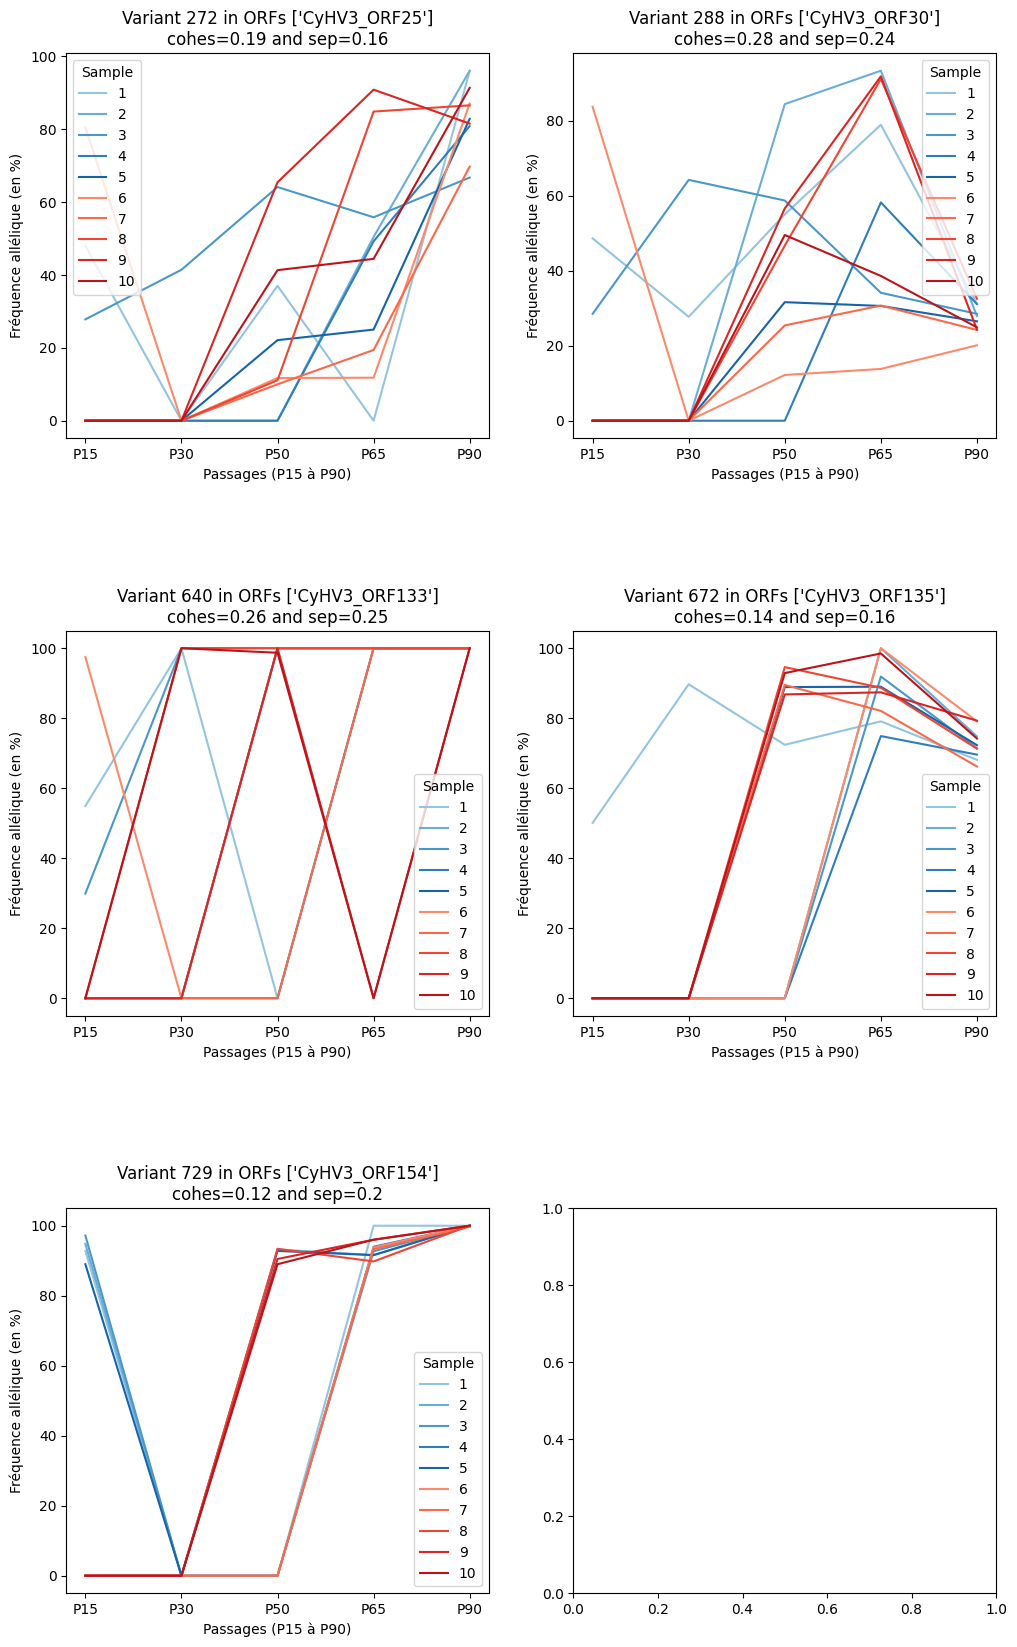

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 20))
plt.subplots_adjust(hspace=0.5)

i = 0
j = 0
for _, row in data_selected.iterrows():
    plot_variant(row, axes[j, i])
    i+=1
    if i > 1:
        i = 0
        j += 1

plt.show()

### Figure pour le rapport

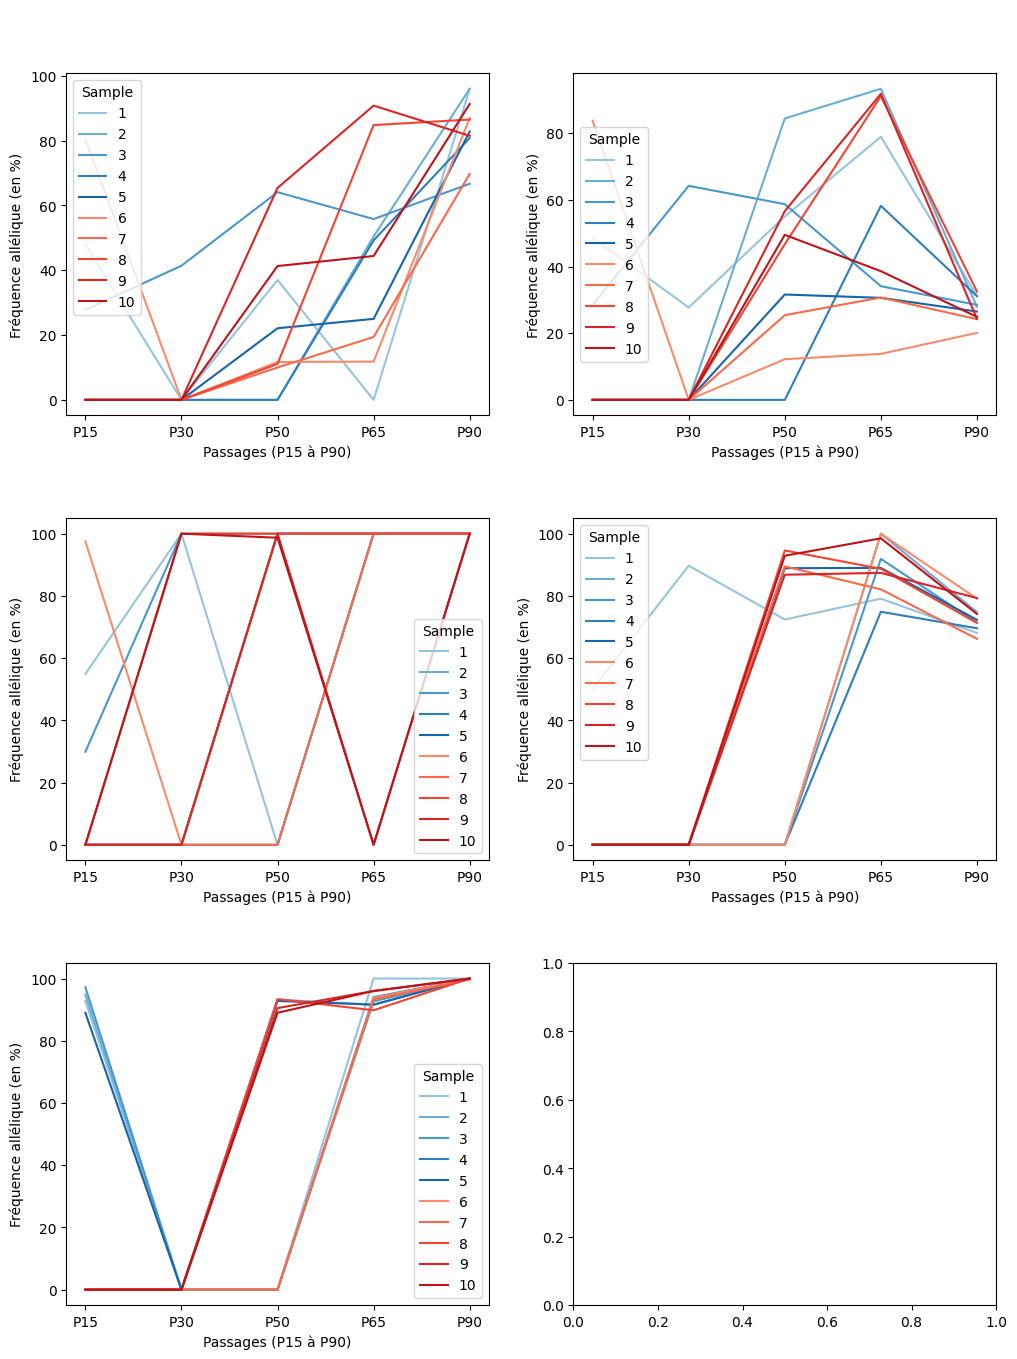

In [39]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(12, 16))
plot_variant(data_selected[data_selected["group"] == 272].iloc[0], ax1, "\n\n")
plot_variant(data_selected[data_selected["group"] == 288].iloc[0], ax2, "")
plot_variant(data_selected[data_selected["group"] == 640].iloc[0], ax3, "")
plot_variant(data_selected[data_selected["group"] == 672].iloc[0], ax4, "")
plot_variant(data_selected[data_selected["group"] == 729].iloc[0], ax5, "")

plt.subplots_adjust(hspace=0.3)

plt.savefig("../results/Figures/candidates_2.pdf")